In [1]:
!pip uninstall opencv-python -y -q
!pip install opencv-python==4.1.2.30 -q
!pip install albumentations --upgrade -q

!pip uninstall opencv-python -y -q
!pip install opencv-python==4.1.2.30 -q
!pip install albumentations --upgrade -q
import albumentations as A
A.__version__

     |████████████████████████████████| 28.3 MB 43.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 102 kB 6.6 MB/s 
     |████████████████████████████████| 47.8 MB 51 kB/s 


'1.1.0'

In [2]:
!nvidia-smi

Thu Jun  2 21:19:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import os
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted

In [4]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/CapstoneDataset/images_concatenate.zip -d /content/capstone_images
capstone_images = natsorted(glob(os.path.join("/content/capstone_images", '*')))

capstone_label_df = pd.read_csv("/content/drive/MyDrive/4-1_Capstone/CapstoneDataset/Capstone_labels.csv")

SAMPLES = 500
os.system("unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/images" + str(SAMPLES) + ".zip -d /content/aihub_images")

aihub_images = natsorted(glob(os.path.join("/content/aihub_images/images" + str(SAMPLES), '*')))
aihub_label_df = pd.read_csv("/content/aihub_images/AI_Label_" + str(SAMPLES)  +".csv")

images = capstone_images + aihub_images
label_df = pd.concat([capstone_label_df, aihub_label_df]).fillna(0.).reset_index(drop = True)

In [9]:
# train_test_split
argmax_classes = []
for label in label_df.values:
    if label.sum() == 1:    argmax_classes.append(label.argmax())
    else:                   argmax_classes.append(4) # 3과 4가 동시에 존재하면 4 데이터가 적으므로 4에 포함시킴

# len(argmax_classes)
from sklearn.model_selection import train_test_split
train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

train_images = np.array(images)[train_i]
val_images   = np.array(images)[val_i]

train_y = label_df.values[train_i]
val_y   = label_df.values[val_i]

In [11]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/gen_all.zip -d /content/gen_all

N_CLASSES = train_y.shape[1]

gen_images = os.listdir("/content/gen_all")

gen_y = [int(f.split('_')[0]) for f in gen_images]
gen_y = np.eye(N_CLASSES)[gen_y]

gen_images = [os.path.join("/content/gen_all", f) for f in gen_images]

train_images = np.concatenate([train_images, gen_images])
train_y      = np.concatenate([train_y, gen_y])

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import cv2

class MyDataset(Dataset):

    def __init__(self, transform=None, split=None):        
        
        self.split = split
        self.transform = transform

        if split.upper() == 'TRAIN':
            self.img_dirs = train_images
            self.y = train_y
        
        if split.upper() == 'VALIDATION':
            self.img_dirs = val_images
            self.y = val_y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):        
        # image = Image.open(self.img_dirs[idx])
        # image = image.convert('RGB')
        # image = self.transform(image)

        image = cv2.imread(self.img_dirs[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Augment an image
        transformed = self.transform(image=image)
        image = transformed["image"]
        y = self.y[idx]

        return image, y

# import torchvision.transforms as T
!pip install timm -q
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# train_tf = T.Compose([
#     # T.Resize(256, interpolation=3),
#     # T.CenterCrop(224),
#     T.Resize(224, interpolation=3),
#     T.ToTensor(),
#     # T.RandomRotation(degrees=(-180, 180)),
#     # T.RandomHorizontalFlip(p=0.5),
#     # T.RandomVerticalFlip(p=0.5), # Rotation을 넣는 순간 Flip은 한개만 수행하면 되며, H-Flip이 V-Flip보다 빠르다.
#     # T.ColorJitter(brightness=.5, contrast=.5),
#     T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
# ])

import albumentations as A
import albumentations.pytorch as A_
train_tf = A.Compose([
    A.Resize(224, 224),
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    A_.transforms.ToTensorV2(),
])

tf = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    A_.transforms.ToTensorV2(),
])

     |████████████████████████████████| 431 kB 7.4 MB/s 


In [6]:
%cd /content/drive/MyDrive/4-1_Capstone
from utils import get_crop_mask

crop_mask = get_crop_mask()
crop_mask = torch.Tensor(crop_mask).cuda()
crop_mask

/content/drive/MyDrive/4-1_Capstone


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [ ]:
%cd /content/drive/MyDrive/4-1_Capstone
from class_balanced_loss import CB_loss
from collections import Counter
samples_per_cls = list(map(float, (Counter(sorted(argmax_classes)).values())))
no_of_classes = len(label_df.columns)
loss_type = "focal" # in [sigmoid, softmax, focal]
beta = 0.9999 # usaually in 0.9, 0.99, 0.999, 0.9999
gamma = 2.0

In [15]:
!pip install timm -q
N_CLASSES = len(label_df.columns)
import torch
import timm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torchvision
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

!pip install wandb -qqq
import wandb
wandb.login(key="9086993130a56abc5cd780b691a69c2618757f73")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calc_macro_f1(preds, GT):
    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)    
    return f1_score(GT, preds_sigmoid, average = 'macro', zero_division = 0)

# method
def train(model, epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3):
    nb_epochs = epoch

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    if      optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif    optimizer == 'RMSprop':
        optimizer = torch.optim.RMSProp(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.BCEWithLogitsLoss().to(device)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4, nb_epochs*2//4, nb_epochs*3//4], gamma=0.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)       

    train_loader = DataLoader(MyDataset(tf, split='TRAIN'),
                            batch_size=batch_size,
                            shuffle=True,
                            # drop_last=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)


    validation_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)

    import warnings
    warnings.filterwarnings('ignore')

    train_losses = []
    val_losses = []
    train_macro_f1 = []
    val_macro_f1 = []
    from tqdm import tqdm
    for epoch in tqdm(range(nb_epochs)):

        losses = 0
        preds = []                
        GTs    = []
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            H = model(X)    
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
            # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
            preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
            GTs.extend((Y.detach().cpu().numpy()* 1).tolist())
            loss = criterion(H, Y)        
            losses += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = losses / len(GTs)
        train_losses.append(train_loss)
        
        train_f1 = calc_macro_f1(preds, GTs)
        train_macro_f1.append(train_f1)

        scheduler.step()
        # print("train_loss = ", train_loss)

        losses = 0
        preds = []                
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)

                H = model(X)
                H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
                # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
                preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
                loss = criterion(H, Y)

                losses += loss.item()
        val_loss = losses / len(val_y)
        val_losses.append(val_loss)
        # print("val_loss = ", val_loss)

        val_f1 = calc_macro_f1(preds, val_y)
        val_macro_f1.append(val_f1)

        print(f"EPOCH {epoch} : TRAIN_LOSS = {train_loss:.4f}  VAL_LOSS = {val_loss:.4f}  TRAIN_F1 = {train_f1:.3f} VAL_F1 = {val_f1:.3f}")
        # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"train-loss": train_loss, "validation-loss": val_loss, "train-f1": train_f1, "val-f1": val_f1})

    # Mark the run as finished
    wandb.finish()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_macro_f1, label='train')
    plt.plot(val_macro_f1, label='val')
    plt.title('macro_f1')
    plt.legend()

    plt.show()


def test(model, batch_size = 32):

    test_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_y, preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

def preds_analysis(preds):
    preds = np.array(preds)

    from collections import Counter
    import matplotlib.pyplot as plt
    for cls in range(len(label_df.columns)):
        plt.figure(figsize=(20,3))
        Actual_y = cls
        x = [str(n) for n in range(len(label_df.columns))]
        y = (preds[val_y[:, Actual_y] == 1] > 0).astype(int).sum(0)

        plt.bar(x, y)
        plt.title(f"Actual_y = {Actual_y}")

        for i in range(len(y)):
            plt.annotate(y[i], (x[i], y[i]), ha = 'center', va = 'bottom')

        plt.show()


def run(model = 'E', epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, memo=None):

    architecture = 'EfficientNet_B0' if model == 'E' else 'DeiT'
    # 🐝 1️⃣ Start a new run to track this script
    wandb.init(
        # Set the project where this run will be logged
        project="debug",
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name = memo, 
        # Track hyperparameters and run metadata
        config={
        "architecture": architecture,
        "epochs": epoch,
        "optimizer": optimizer,
        "learning_rate": lr,
        })
    
    from torch.nn import Linear
    N_CLASSES = 72
    if model == 'E':
        model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
        model.classifier = Linear(in_features=1280, out_features=N_CLASSES, bias=True)

    if model == 'D':
        model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        model.head = Linear(in_features=768, out_features=N_CLASSES, bias=True)
    
    train(model, epoch, batch_size, optimizer, lr)
    preds = test(model)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1. EfficientNet B0

wandb: Currently logged in as: bjjun970. Use `wandb login --relogin` to force relogin


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  3%|▎         | 1/30 [03:13<1:33:22, 193.19s/it]

EPOCH 0 : TRAIN_LOSS = 0.0008  VAL_LOSS = 0.0004  TRAIN_F1 = 0.600 VAL_F1 = 0.769


  7%|▋         | 2/30 [06:21<1:28:47, 190.28s/it]

EPOCH 1 : TRAIN_LOSS = 0.0003  VAL_LOSS = 0.0002  TRAIN_F1 = 0.801 VAL_F1 = 0.838


 10%|█         | 3/30 [09:38<1:27:02, 193.41s/it]

EPOCH 2 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.846 VAL_F1 = 0.841


 13%|█▎        | 4/30 [12:46<1:22:55, 191.38s/it]

EPOCH 3 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.873 VAL_F1 = 0.868


 17%|█▋        | 5/30 [15:55<1:19:22, 190.49s/it]

EPOCH 4 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.909 VAL_F1 = 0.868


 20%|██        | 6/30 [19:02<1:15:37, 189.08s/it]

EPOCH 5 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.929 VAL_F1 = 0.863


 23%|██▎       | 7/30 [22:08<1:12:09, 188.24s/it]

EPOCH 6 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.959 VAL_F1 = 0.891


 27%|██▋       | 8/30 [25:14<1:08:47, 187.60s/it]

EPOCH 7 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.980 VAL_F1 = 0.892


 30%|███       | 9/30 [28:21<1:05:30, 187.19s/it]

EPOCH 8 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.990 VAL_F1 = 0.899


 33%|███▎      | 10/30 [31:26<1:02:15, 186.79s/it]

EPOCH 9 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.993 VAL_F1 = 0.900


 37%|███▋      | 11/30 [34:33<59:07, 186.69s/it]  

EPOCH 10 : TRAIN_LOSS = 0.0003  VAL_LOSS = 0.0002  TRAIN_F1 = 0.830 VAL_F1 = 0.840


 40%|████      | 12/30 [37:40<56:02, 186.79s/it]

EPOCH 11 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.897 VAL_F1 = 0.859


 43%|████▎     | 13/30 [40:48<53:01, 187.13s/it]

EPOCH 12 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.921 VAL_F1 = 0.860


 47%|████▋     | 14/30 [43:56<49:59, 187.45s/it]

EPOCH 13 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.940 VAL_F1 = 0.867


 50%|█████     | 15/30 [47:03<46:50, 187.35s/it]

EPOCH 14 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.959 VAL_F1 = 0.880


 53%|█████▎    | 16/30 [50:10<43:39, 187.12s/it]

EPOCH 15 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.976 VAL_F1 = 0.885


 57%|█████▋    | 17/30 [53:17<40:32, 187.08s/it]

EPOCH 16 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.985 VAL_F1 = 0.893


 60%|██████    | 18/30 [56:23<37:22, 186.86s/it]

EPOCH 17 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.992 VAL_F1 = 0.890


 63%|██████▎   | 19/30 [59:30<34:13, 186.72s/it]

EPOCH 18 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.993 VAL_F1 = 0.895


 67%|██████▋   | 20/30 [1:02:36<31:05, 186.57s/it]

EPOCH 19 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.995 VAL_F1 = 0.897


 70%|███████   | 21/30 [1:05:43<27:59, 186.64s/it]

EPOCH 20 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.878 VAL_F1 = 0.853


 73%|███████▎  | 22/30 [1:08:49<24:53, 186.71s/it]

EPOCH 21 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.940 VAL_F1 = 0.872


 77%|███████▋  | 23/30 [1:11:58<21:49, 187.12s/it]

EPOCH 22 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.955 VAL_F1 = 0.876


 80%|████████  | 24/30 [1:15:05<18:43, 187.19s/it]

EPOCH 23 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.966 VAL_F1 = 0.880


 83%|████████▎ | 25/30 [1:18:13<15:36, 187.35s/it]

EPOCH 24 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.977 VAL_F1 = 0.872


 87%|████████▋ | 26/30 [1:21:20<12:29, 187.25s/it]

EPOCH 25 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.985 VAL_F1 = 0.879


 90%|█████████ | 27/30 [1:24:27<09:21, 187.29s/it]

EPOCH 26 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.991 VAL_F1 = 0.888


 93%|█████████▎| 28/30 [1:27:33<06:14, 187.03s/it]

EPOCH 27 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.993 VAL_F1 = 0.893


 97%|█████████▋| 29/30 [1:30:41<03:07, 187.25s/it]

EPOCH 28 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.994 VAL_F1 = 0.895


100%|██████████| 30/30 [1:33:49<00:00, 187.65s/it]

EPOCH 29 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.995 VAL_F1 = 0.895


train-f1,▁▅▅▆▆▇▇███▅▆▇▇▇█████▆▇▇▇██████
train-loss,█▄▃▃▂▂▁▁▁▁▄▂▂▂▂▁▁▁▁▁▃▂▂▁▁▁▁▁▁▁
val-f1,▁▅▅▆▆▆████▅▆▆▆▇▇█▇██▆▆▇▇▇▇▇███
validation-loss,█▃▂▁▂▂▁▂▂▂▃▂▃▂▂▃▃▃▃▃▃▃▃▃▄▅▅▄▄▅
train-f1,0.99472
train-loss,1e-05
val-f1,0.89522
validation-loss,0.00029


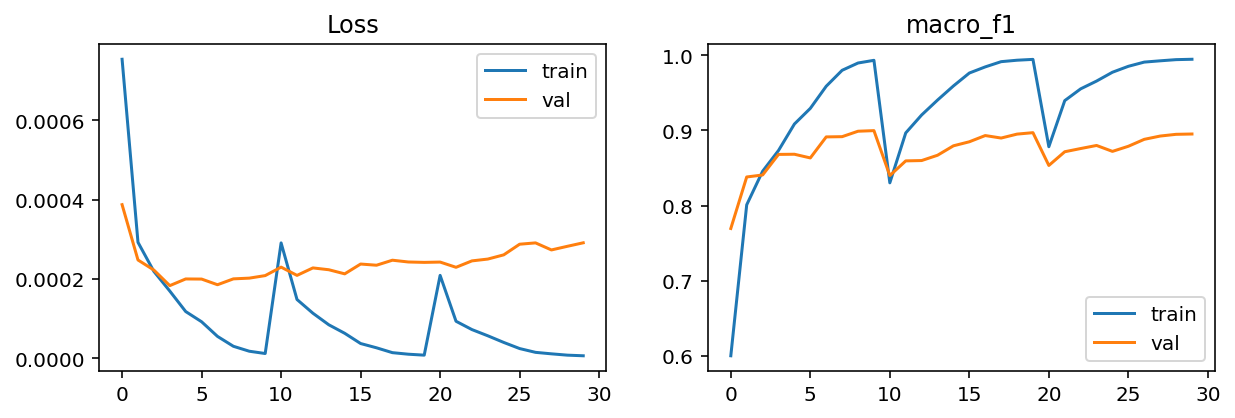

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00       139
           2       1.00      1.00      1.00       311
           3       0.97      0.96      0.96       727
           4       0.83      0.88      0.85        65
           5       1.00      1.00      1.00       420
           6       0.97      1.00      0.98       273
           7       0.99      0.97      0.98       299
           8       0.99      0.99      0.99       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       0.98      0.99      0.98       283
          12       0.96      0.93      0.94       125
          13       0.64      0.78      0.70        81
          14       0.85      0.73      0.78       125
          15       0.97      1.00      0.98       125
          16       0.98      0.96      0.97       125
          17       0.97    

In [10]:
run(model = 'E', epoch= 30, batch_size = 32, optimizer='AdamW', memo = "BaseLine 30_crop_no_aware")

  3%|▎         | 1/30 [03:32<1:42:52, 212.85s/it]

EPOCH 0 : TRAIN_LOSS = 0.0007  VAL_LOSS = 0.0003  TRAIN_F1 = 0.627 VAL_F1 = 0.780


  7%|▋         | 2/30 [07:06<1:39:31, 213.27s/it]

EPOCH 1 : TRAIN_LOSS = 0.0003  VAL_LOSS = 0.0003  TRAIN_F1 = 0.830 VAL_F1 = 0.799


 10%|█         | 3/30 [10:38<1:35:45, 212.78s/it]

EPOCH 2 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.869 VAL_F1 = 0.845


 13%|█▎        | 4/30 [14:10<1:32:05, 212.53s/it]

EPOCH 3 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.897 VAL_F1 = 0.858


 17%|█▋        | 5/30 [17:43<1:28:31, 212.45s/it]

EPOCH 4 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.922 VAL_F1 = 0.870


 20%|██        | 6/30 [21:15<1:24:56, 212.37s/it]

EPOCH 5 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.946 VAL_F1 = 0.880


 23%|██▎       | 7/30 [24:49<1:21:40, 213.05s/it]

EPOCH 6 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.964 VAL_F1 = 0.894


 27%|██▋       | 8/30 [28:22<1:18:05, 212.97s/it]

EPOCH 7 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.981 VAL_F1 = 0.892


 30%|███       | 9/30 [31:58<1:14:55, 214.05s/it]

EPOCH 8 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.990 VAL_F1 = 0.895


 33%|███▎      | 10/30 [35:33<1:11:23, 214.17s/it]

EPOCH 9 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.994 VAL_F1 = 0.899


 37%|███▋      | 11/30 [39:07<1:07:46, 214.04s/it]

EPOCH 10 : TRAIN_LOSS = 0.0003  VAL_LOSS = 0.0002  TRAIN_F1 = 0.853 VAL_F1 = 0.847


 40%|████      | 12/30 [42:41<1:04:14, 214.11s/it]

EPOCH 11 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.915 VAL_F1 = 0.850


 43%|████▎     | 13/30 [46:15<1:00:42, 214.25s/it]

EPOCH 12 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.936 VAL_F1 = 0.871


 47%|████▋     | 14/30 [49:48<56:58, 213.68s/it]  

EPOCH 13 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.945 VAL_F1 = 0.873


 50%|█████     | 15/30 [53:22<53:27, 213.87s/it]

EPOCH 14 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.964 VAL_F1 = 0.874


 53%|█████▎    | 16/30 [56:57<49:56, 214.02s/it]

EPOCH 15 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.978 VAL_F1 = 0.883


 57%|█████▋    | 17/30 [1:00:33<46:30, 214.66s/it]

EPOCH 16 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.987 VAL_F1 = 0.890


 60%|██████    | 18/30 [1:04:06<42:52, 214.35s/it]

EPOCH 17 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.992 VAL_F1 = 0.895


 63%|██████▎   | 19/30 [1:07:40<39:14, 214.07s/it]

EPOCH 18 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.994 VAL_F1 = 0.898


 67%|██████▋   | 20/30 [1:11:13<35:39, 213.98s/it]

EPOCH 19 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0002  TRAIN_F1 = 0.995 VAL_F1 = 0.900


 70%|███████   | 21/30 [1:14:48<32:07, 214.17s/it]

EPOCH 20 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0003  TRAIN_F1 = 0.900 VAL_F1 = 0.850


 73%|███████▎  | 22/30 [1:18:22<28:32, 214.10s/it]

EPOCH 21 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.948 VAL_F1 = 0.870


 77%|███████▋  | 23/30 [1:21:58<25:03, 214.79s/it]

EPOCH 22 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.961 VAL_F1 = 0.874


 80%|████████  | 24/30 [1:25:33<21:27, 214.62s/it]

EPOCH 23 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.970 VAL_F1 = 0.882


 83%|████████▎ | 25/30 [1:29:08<17:53, 214.76s/it]

EPOCH 24 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.979 VAL_F1 = 0.878


 87%|████████▋ | 26/30 [1:32:42<14:18, 214.66s/it]

EPOCH 25 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.987 VAL_F1 = 0.883


 90%|█████████ | 27/30 [1:36:16<10:43, 214.51s/it]

EPOCH 26 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.991 VAL_F1 = 0.892


 93%|█████████▎| 28/30 [1:39:52<07:09, 214.97s/it]

EPOCH 27 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.994 VAL_F1 = 0.895


 97%|█████████▋| 29/30 [1:43:27<03:34, 214.86s/it]

EPOCH 28 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.995 VAL_F1 = 0.897


100%|██████████| 30/30 [1:47:02<00:00, 214.08s/it]

EPOCH 29 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.996 VAL_F1 = 0.897


train-f1,▁▅▆▆▇▇▇███▅▆▇▇▇█████▆▇▇███████
train-loss,█▄▃▃▂▂▁▁▁▁▄▂▂▂▂▁▁▁▁▁▃▂▂▁▁▁▁▁▁▁
val-f1,▁▂▅▆▆▇████▅▅▆▆▆▇▇███▅▆▆▇▇▇████
validation-loss,█▇▃▃▁▁▁▂▃▃▃▆▃▃▃▄▄▄▅▄▅▄▅▅▅▆▅▆▅▅
train-f1,0.99579
train-loss,1e-05
val-f1,0.89711
validation-loss,0.00026


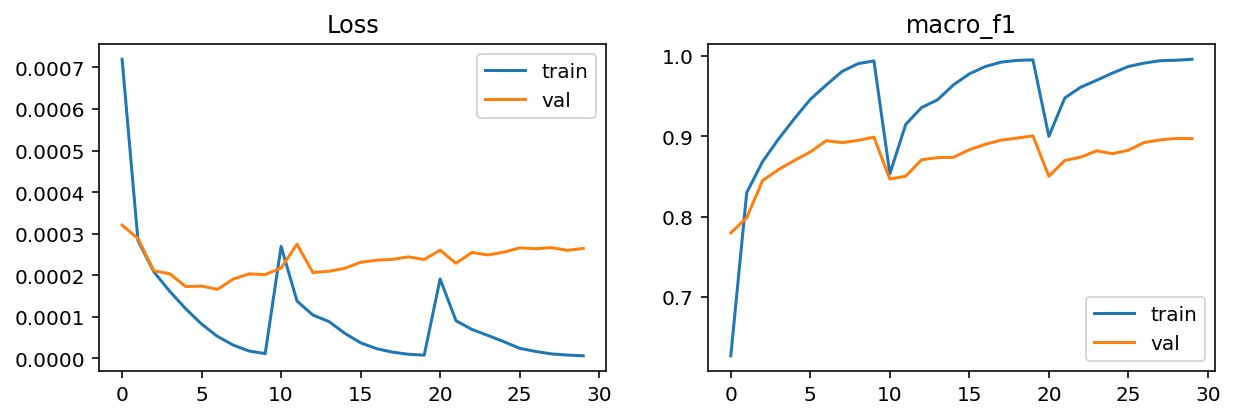

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00       139
           2       1.00      1.00      1.00       311
           3       0.97      0.96      0.96       727
           4       0.85      0.86      0.85        65
           5       0.99      1.00      0.99       420
           6       0.99      1.00      0.99       273
           7       0.99      0.99      0.99       299
           8       0.99      1.00      0.99       413
           9       1.00      1.00      1.00       361
          10       1.00      0.99      1.00       142
          11       0.99      1.00      0.99       283
          12       0.96      0.94      0.95       125
          13       0.70      0.74      0.72        81
          14       0.82      0.77      0.79       125
          15       0.99      0.99      0.99       125
          16       0.99      0.99      0.99       125
          17       0.99    

In [12]:
run(model = 'E', epoch= 30, batch_size = 32, optimizer='AdamW', memo = "GAN 30_crop_no_aware")

  3%|▎         | 1/30 [03:37<1:45:18, 217.89s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0206  TRAIN_F1 = 0.926 VAL_F1 = 0.927


  7%|▋         | 2/30 [07:12<1:40:41, 215.77s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.966 VAL_F1 = 0.942


 10%|█         | 3/30 [10:48<1:37:12, 216.03s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.975 VAL_F1 = 0.949


 13%|█▎        | 4/30 [14:24<1:33:32, 215.86s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.981 VAL_F1 = 0.951


 17%|█▋        | 5/30 [17:59<1:29:52, 215.70s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.985 VAL_F1 = 0.960


 20%|██        | 6/30 [21:35<1:26:16, 215.70s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.990 VAL_F1 = 0.961


 23%|██▎       | 7/30 [25:11<1:22:47, 215.97s/it]

EPOCH 6 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.995 VAL_F1 = 0.964


 27%|██▋       | 8/30 [28:48<1:19:14, 216.13s/it]

EPOCH 7 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.997 VAL_F1 = 0.970


 30%|███       | 9/30 [32:25<1:15:43, 216.36s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.998 VAL_F1 = 0.969


 33%|███▎      | 10/30 [36:03<1:12:18, 216.92s/it]

EPOCH 9 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.999 VAL_F1 = 0.971


 37%|███▋      | 11/30 [39:41<1:08:48, 217.28s/it]

EPOCH 10 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.957 VAL_F1 = 0.944


 40%|████      | 12/30 [43:19<1:05:13, 217.44s/it]

EPOCH 11 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.982 VAL_F1 = 0.955


 43%|████▎     | 13/30 [46:55<1:01:31, 217.13s/it]

EPOCH 12 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.985 VAL_F1 = 0.955


 47%|████▋     | 14/30 [50:32<57:52, 217.03s/it]  

EPOCH 13 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.989 VAL_F1 = 0.953


 50%|█████     | 15/30 [54:09<54:16, 217.09s/it]

EPOCH 14 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.992 VAL_F1 = 0.959


 53%|█████▎    | 16/30 [57:46<50:38, 217.04s/it]

EPOCH 15 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.995 VAL_F1 = 0.962


 57%|█████▋    | 17/30 [1:01:23<47:02, 217.11s/it]

EPOCH 16 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.997 VAL_F1 = 0.960


 60%|██████    | 18/30 [1:05:01<43:25, 217.13s/it]

EPOCH 17 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.998 VAL_F1 = 0.966


 63%|██████▎   | 19/30 [1:08:37<39:45, 216.82s/it]

EPOCH 18 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.998 VAL_F1 = 0.967


 67%|██████▋   | 20/30 [1:12:14<36:08, 216.88s/it]

EPOCH 19 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.999 VAL_F1 = 0.967


 70%|███████   | 21/30 [1:15:51<32:32, 216.97s/it]

EPOCH 20 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.970 VAL_F1 = 0.954


 73%|███████▎  | 22/30 [1:19:27<28:53, 216.65s/it]

EPOCH 21 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.988 VAL_F1 = 0.954


 77%|███████▋  | 23/30 [1:23:04<25:18, 216.94s/it]

EPOCH 22 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.989 VAL_F1 = 0.959


 80%|████████  | 24/30 [1:26:44<21:45, 217.65s/it]

EPOCH 23 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.994 VAL_F1 = 0.957


 83%|████████▎ | 25/30 [1:30:23<18:11, 218.29s/it]

EPOCH 24 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.995 VAL_F1 = 0.963


 87%|████████▋ | 26/30 [1:34:07<14:39, 219.96s/it]

EPOCH 25 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.996 VAL_F1 = 0.960


 90%|█████████ | 27/30 [1:37:52<11:04, 221.54s/it]

EPOCH 26 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.998 VAL_F1 = 0.964


 93%|█████████▎| 28/30 [1:41:38<07:25, 222.70s/it]

EPOCH 27 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.999 VAL_F1 = 0.965


 97%|█████████▋| 29/30 [1:45:24<03:43, 223.76s/it]

EPOCH 28 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.999 VAL_F1 = 0.966


100%|██████████| 30/30 [1:49:11<00:00, 218.38s/it]

EPOCH 29 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.999 VAL_F1 = 0.966


train-f1,▁▅▆▆▇▇████▄▆▇▇▇█████▅▇▇▇██████
train-loss,█▅▄▃▂▂▂▁▁▁▅▃▃▂▂▁▁▁▁▁▄▂▂▂▁▁▁▁▁▁
val-f1,▁▄▄▅▆▆▇███▄▆▅▅▆▇▆▇▇▇▅▅▆▆▇▆▇▇▇▇
validation-loss,█▄▃▅▁▂▁▁▂▂▅▃▂▄▄▃▃▂▃▃▄▃▂▄▄▂▃▄▄▄
train-f1,0.99895
train-loss,0.02053
val-f1,0.96553
validation-loss,0.02062


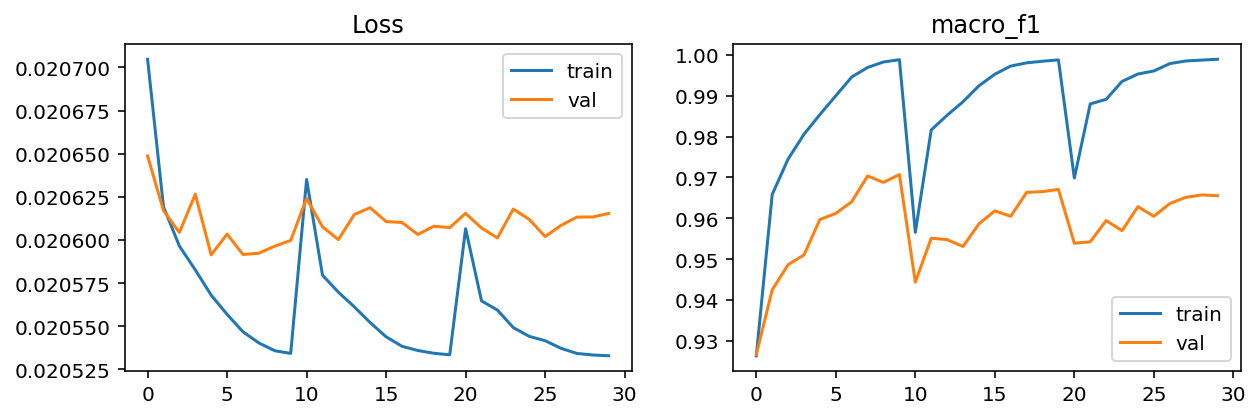

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      0.99      1.00       139
           2       0.99      1.00      1.00       311
           3       0.97      0.96      0.96       727
           4       0.81      0.88      0.84        65
           5       1.00      1.00      1.00       420
           6       0.97      0.99      0.98       273
           7       0.99      0.96      0.97       299
           8       1.00      0.99      0.99       413
           9       1.00      1.00      1.00       361
          10       0.99      0.99      0.99       142
          11       0.99      0.99      0.99       283
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00        81
          14       1.00      0.99      1.00       125
          15       0.99      1.00      1.00       125
          16       1.00      0.98      0.99       125
          17       0.99    

In [17]:
run(model = 'E', epoch= 30, batch_size = 32, optimizer='AdamW', memo = "GAN 30+crop_aware+no_augmentation")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 10%|█         | 1/10 [03:54<35:14, 234.96s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0207  TRAIN_F1 = 0.015 VAL_F1 = 0.919


 20%|██        | 2/10 [07:31<29:53, 224.18s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.955


 30%|███       | 3/10 [11:06<25:40, 220.01s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.968


 40%|████      | 4/10 [14:42<21:51, 218.51s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.945


 50%|█████     | 5/10 [18:19<18:08, 217.72s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.954


 60%|██████    | 6/10 [21:54<14:27, 216.87s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.968


 70%|███████   | 7/10 [25:30<10:49, 216.62s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.957


 80%|████████  | 8/10 [29:04<07:11, 215.63s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.957


 90%|█████████ | 9/10 [32:40<03:35, 215.87s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.968


100%|██████████| 10/10 [36:15<00:00, 217.54s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.952


train-f1,█▁▅▄▆█▇▅▄▅
train-loss,█▃▂▄▂▁▃▂▁▃
val-f1,▁▆█▅▆█▆▆█▆
validation-loss,█▃▁▄▃▁▂▂▂▃
train-f1,0.01385
train-loss,0.02059
val-f1,0.95203
validation-loss,0.02061


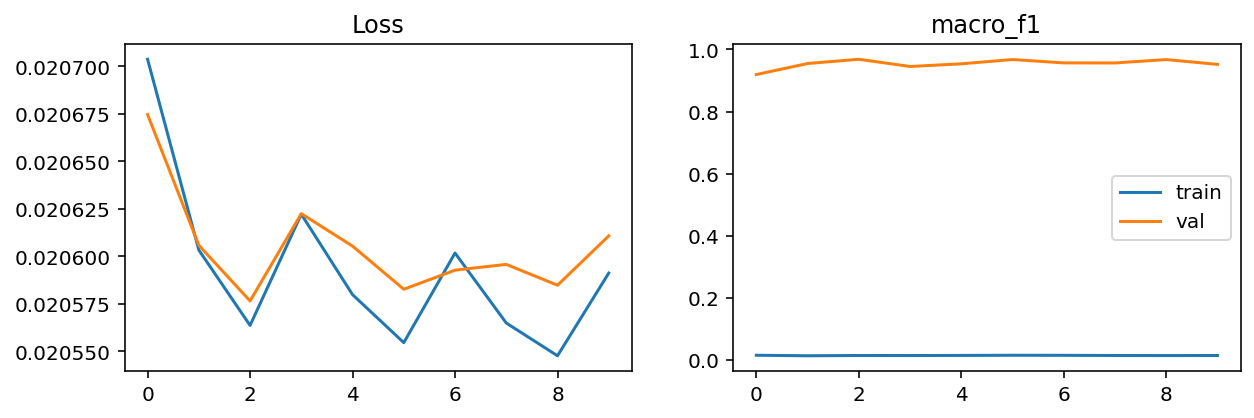

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      0.98      0.99       139
           2       0.99      1.00      1.00       311
           3       0.97      0.98      0.97       727
           4       0.72      0.92      0.81        65
           5       0.98      1.00      0.99       420
           6       0.97      0.96      0.96       273
           7       0.96      0.95      0.96       299
           8       0.98      0.96      0.97       413
           9       1.00      1.00      1.00       361
          10       1.00      0.99      0.99       142
          11       0.93      0.99      0.96       283
          12       1.00      0.98      0.99       125
          13       0.96      1.00      0.98        81
          14       0.96      0.99      0.98       125
          15       0.99      0.99      0.99       125
          16       1.00      1.00      1.00       125
          17       0.97    

In [ ]:
run(model = 'E', epoch= 10, batch_size = 32, optimizer='AdamW', memo = "GAN") # No Augmentation